# BF self energy

Notebook for the analysis of BF self energy, including tests for Monte Carlo sampler

## Setup

In [2]:
using CSV
using DataFrames
using HalfIntegers, JLD2, Distributions, Random
using LaTeXStrings

In [3]:
using Statistics
using StatsBase
using StatsPlots

In [4]:
# this allows to save images as eps using the "savefig" function, but it changes the plot style as well
# pyplot()

To save images in eps, we run *imagemagick* via shell command

In [5]:
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    grid = :true,
    gridlinewidth = 0.5,
    fontfamily="Computer Modern",
    framestyle=:box,
    size=(800,300),
    margin=5Plots.mm
)
scalefontsizes(1.3)

# Decide how many monte carlo samples we take

We compare the results of MC sampling with $N_{mc}=1\,000$, $N_{mc}=10\,000$, $N_{mc}=100\,000$ samples. We compare with the exact result for the amplitude. 
We estimate the value of the Layers averaging over 20 trials and the error with the standard deviation. Then we sum the average value of the layers and we sum variances

In [12]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/EPRL/immirzi_0.1/Dl_10/ampls_cutoff_10_ib_0.0_trial_$(trial).csv",
        ),
    )
end
# weight_1.0/ib_0

get_data (generic function with 1 method)

In [14]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc1K = error_Nmc1K./amplitude_Nmc1K;

In [15]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc10K = error_Nmc10K./amplitude_Nmc10K;

In [16]:
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_error_Nmc100K = error_Nmc100K./amplitude_Nmc100K;


plot1 = Plot{Plots.GRBackend() n=3}


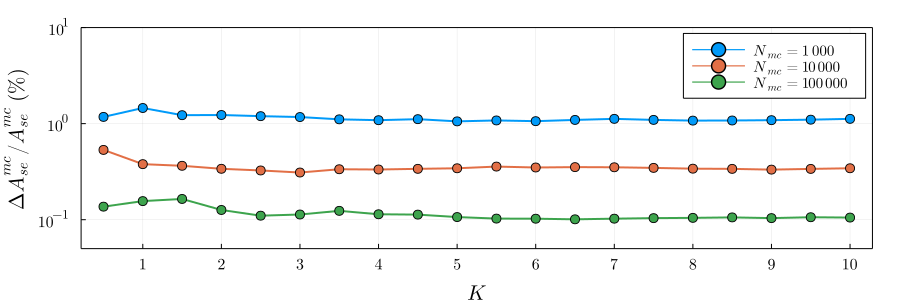

In [19]:
plot1 = plot(0.5:0.5:10,
               [100*relative_error_Nmc1K, 100*relative_error_Nmc10K,100*relative_error_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylim = (0.05,10),
               ylabel = L"\Delta A_{se}^{mc}/A_{se}^{mc}  \ (\%)",
               xlabel = L"K",
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm
               )
# #title!(plot1, "Monte Carlo error")
# savefig(plot1,"./plots/BF/self_energy/Nmctest.svg")
# savefig(plot1,"./plots/BF/self_energy/Nmctest.pdf")

@show plot1


In [87]:
#run(`convert -density 300 -trim ./plots/BF/self_energy/Nmctest.svg -quality 100 ./plots/BF/self_energy/Nmctest.eps`)

Process(`convert -density 300 -trim ./plots/BF/self_energy/Nmctest.svg -quality 100 ./plots/BF/self_energy/Nmctest.eps`, ProcessExited(0))

In [20]:
function get_self_energy_exact()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/EPRL/immirzi_0.1/Dl_10/ampls_cutoff_10_ib_0.0.csv",
        ),
    )
end
exact_amplitude = get_self_energy_exact().amp[2:end];


relative_Nmc100K  = 100 .*(amplitude_Nmc100K ./exact_amplitude .-1);
error_relative_Nmc100K = 100 .* error_Nmc100K ./exact_amplitude;


plot2 = Plot{Plots.GRBackend() n=1}


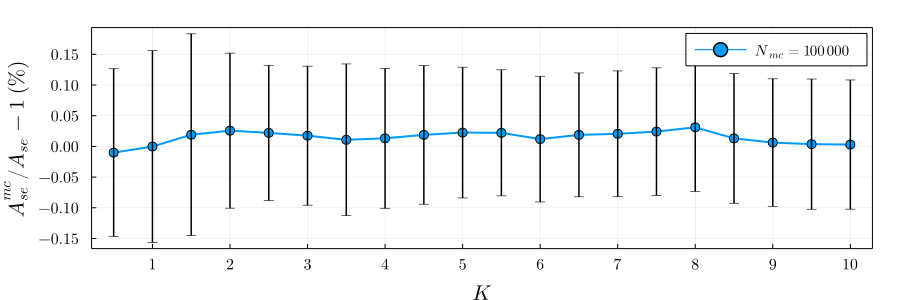

In [21]:
plot2 = plot(0.5:0.5:10,
               relative_Nmc100K,
               label =  L"$N_{mc}=100\,000$",
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylabel = L"A_{se}^{mc}/A_{se} -1  \ (\%)",
               xlabel = L"K",
               yerror= error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               margin=5Plots.mm
               )

#title!(plot2, "Monte Carlo error compared with exact amplitude")
# savefig(plot2,"./plots/BF/self_energy/with_error_bars.svg")
# savefig(plot2,"./plots/BF/self_energy/with_error_bars.pdf")

@show plot2

In [91]:
#run(`convert -density 300 -trim ./plots/BF/self_energy/with_error_bars.svg -quality 100 ./plots/BF/self_energy/with_error_bars.eps`)

Process(`convert -density 300 -trim ./plots/BF/self_energy/with_error_bars.svg -quality 100 ./plots/BF/self_energy/with_error_bars.eps`, ProcessExited(0))

Even in loglog scale the exact and the MC are the one on top of the other

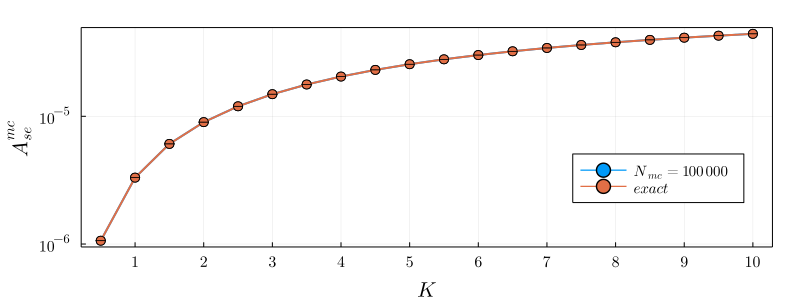

In [22]:
plot3 = plot(0.5:0.5:10,
               [amplitude_Nmc100K,exact_amplitude],
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  [L"$N_{mc}=100\,000$" L"exact"],
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.80,0.35),
               ylabel = L"A_{se}^{mc}",
               xlabel = L"K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               margin=5Plots.mm
               )

# Fitting the amplitude to find the scaling

We fit the amplitude as a function of the cutoff K using least squares fit. We use as a model the function 
$$ c_2K^{c_1} +  c_3 K^{c_1-1} +  c_4$$
and we perform the fit using only the last 10-ish points.

In [23]:
using LsqFit

In [35]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], exact_amplitude[10:end], c0)
fit.param

4-element Vector{Float64}:
  1.713640114703428
 -2.7025356514630063e-7
  1.4053534841039715e-5
 -1.4497157941818678e-5

The error is computed automatically by the library. We use the 95% CI.

In [36]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.02898205756738991
 5.212571317449801e-9
 1.105359181001912e-6
 1.5446299822444752e-6

In [37]:
estimate_covar(fit)

4×4 Matrix{Float64}:
  0.000150222   2.5151e-11   -5.72666e-9    7.99506e-9
  2.5151e-11    4.85937e-18  -9.70348e-16   1.36599e-15
 -5.72666e-9   -9.70348e-16   2.18516e-13  -3.05278e-13
  7.99506e-9    1.36599e-15  -3.05278e-13   4.26702e-13

Visual check that the amplitude is compatible with the fit even with a bad fit!

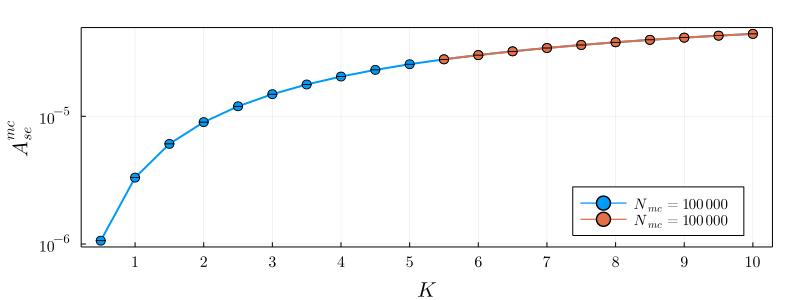

In [33]:
plot3 = plot(0.5:0.5:10,
               amplitude_Nmc100K,
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.20),
               ylabel = L"A_{se}^{mc}",
               xlabel = L"K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )
plot3 = plot!(5.5:0.5:10,
               [model(K,fit.param) for K in 5.5:0.5:10],
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               yscale=:log10,
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.8,0.20),
               ylabel = L"A_{se}^{mc}",
               xlabel = L"K",
               yerror= error_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               grid=true,
               )

The issue with the fit beign so bad has nothing to do with the Monte Carlo estimate. The fit we showed here is done using the exact amplitude. We can repeat it using the MonteCarlo amplitude to obtain very similar results.

In [ ]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param;

In [ ]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
  0.5923191377902849
 30.20699670526499
 62.947548904599614
  4.8598050049470775e6

We cannot discriminate between $c_1=8$, $8.5$ or $9$. To circumvent this problem we look at the amplitudes with modified face amplitude 
$$ A_f(j_f) = (2j_f+1) \to (2j_f+1)^\mu$$
using as possible values of $\mu=1/6$, $\mu=0$, and $\mu=-1/6$.

In [ ]:
function get_data_mum16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_-0.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mum16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_-0.167/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mum16 = get_self_energy_exact_mum16().amp[2:end];

In [ ]:
function get_data_mum16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_-0.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mum16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_-0.167/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mum16 = get_self_energy_exact_mum16().amp[2:end];

In [ ]:
function get_data_mum16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_-0.167/ib_0/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mum16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_-0.167/ib_0/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mum16 = get_self_energy_exact_mum16().amp[2:end];

In [ ]:
layers_trials_mum16 = DataFrame()
for trial in 1:20
    layers_trials_mum16[!,"$(trial)"]=[get_data_mum16(100000, trial).amp[id] - get_data_mum16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mum16 =  [mean(row) for row in eachrow(layers_trials_mum16)];
layers_variance_mum16 =  [var(row) for row in eachrow(layers_trials_mum16)];
amplitude_Nmc100K_mum16 = [sum(layers_average_mum16[1:id]) for id in 1:20];
error_Nmc100K_mum16 = sqrt.([sum(layers_variance_mum16[1:id]) for id in 1:20]);


relative_Nmc100K_mum16 = amplitude_Nmc100K_mum16./exact_amplitude_mum16 .-1;
error_relative_Nmc100K_mum16 = error_Nmc100K_mum16./exact_amplitude_mum16;

In [ ]:
layers_trials_mum16 = DataFrame()
for trial in 1:20
    layers_trials_mum16[!,"$(trial)"]=[get_data_mum16(100000, trial).amp[id] - get_data_mum16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mum16 =  [mean(row) for row in eachrow(layers_trials_mum16)];
layers_variance_mum16 =  [var(row) for row in eachrow(layers_trials_mum16)];
amplitude_Nmc100K_mum16 = [sum(layers_average_mum16[1:id]) for id in 1:20];
error_Nmc100K_mum16 = sqrt.([sum(layers_variance_mum16[1:id]) for id in 1:20]);


relative_Nmc100K_mum16 = amplitude_Nmc100K_mum16./exact_amplitude_mum16 .-1;
error_relative_Nmc100K_mum16 = error_Nmc100K_mum16./exact_amplitude_mum16;

In [ ]:
layers_trials_mum16 = DataFrame()
for trial in 1:20
    layers_trials_mum16[!,"$(trial)"]=[get_data_mum16(100000, trial).amp[id] - get_data_mum16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mum16 =  [mean(row) for row in eachrow(layers_trials_mum16)];
layers_variance_mum16 =  [var(row) for row in eachrow(layers_trials_mum16)];
amplitude_Nmc100K_mum16 = [sum(layers_average_mum16[1:id]) for id in 1:20];
error_Nmc100K_mum16 = sqrt.([sum(layers_variance_mum16[1:id]) for id in 1:20]);


relative_Nmc100K_mum16 = amplitude_Nmc100K_mum16./exact_amplitude_mum16 .-1;
error_relative_Nmc100K_mum16 = error_Nmc100K_mum16./exact_amplitude_mum16;

pl = Plot{Plots.GRBackend() n=3}


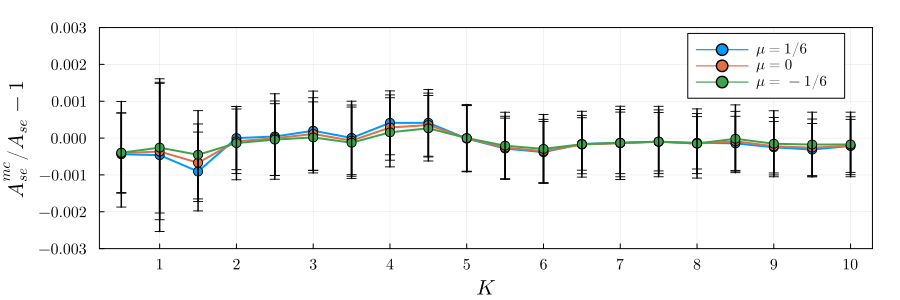

In [50]:
pl = plot(0.5:0.5:10,
   relative_Nmc100K_mu16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu = 1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{se}^{mc}/A_{se} -1",
   xlabel = L"K",
   ylim = (-0.003, 0.003),
   yerror= error_relative_Nmc100K_mu16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )
   
plot!(0.5:0.5:10,
   relative_Nmc100K_mu0,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=0$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{se}^{mc}/A_{se} -1",
   xlabel = L"K",
   yerror= error_relative_Nmc100K_mu0,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

plot!(0.5:0.5:10,
   relative_Nmc100K_mum16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=-1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{se}^{mc}/A_{se} -1 ",
   xlabel = L"K",
   yerror= error_relative_Nmc100K_mum16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

savefig(pl,"./plots/BF/self_energy/with_error_bars_othermus.svg")
savefig(pl,"./plots/BF/self_energy/with_error_bars_othermus.pdf")

@show pl

In [76]:
#run(`convert -density 300 -trim ./plots/BF/self_energy/with_error_bars_othermus.svg -quality 100 ./plots/BF/self_energy/with_error_bars_othermus.eps`)

Process(`convert -density 300 -trim ./plots/BF/self_energy/with_error_bars_othermus.svg -quality 100 ./plots/BF/self_energy/with_error_bars_othermus.eps`, ProcessExited(0))

The Monte Carlo approximation of the amplitude works well also in the case of modified $\mu$

We fit the amplitude with $\mu=1/6$

In [51]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [2.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[8:end], amplitude_Nmc100K_mum16[8:end], c0)
fit.param;

In [52]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.013860494589023765
 0.12774615143042722
 0.47918063716249837
 0.7499298263361727

It is reasonable that the exponent is not exactly compatible with $4$ since we are just using an approximation for the scaling. 

In [53]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [2.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[8:end], amplitude_Nmc100K_mum16[8:end], c0)
fit.param;

In [54]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.013860494589023765
 0.12774615143042722
 0.47918063716249837
 0.7499298263361727

In [55]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [2.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[8:end], amplitude_Nmc100K_mum16[8:end], c0)
fit.param;

In [56]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.013860494589023765
 0.12774615143042722
 0.47918063716249837
 0.7499298263361727

# Repeat the analysis for the other boundary intertwiner

In [57]:
BASE_DATA_DIRECTORY = "../../data";
function get_data(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_1.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_1.0/ib_1/ampls_cutoff_10.csv",
        ),
    )
end

get_self_energy_exact (generic function with 1 method)

In [58]:
exact_amplitude = get_self_energy_exact().amp[2:end];
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(1000, trial).amp[id] - get_data(1000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc1K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc1K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);
relative_Nmc1K = amplitude_Nmc1K./exact_amplitude .-1;
error_relative_Nmc1K = error_Nmc1K./exact_amplitude;
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(10000, trial).amp[id] - get_data(10000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc10K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc10K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc10K = amplitude_Nmc10K./exact_amplitude .-1;
error_relative_Nmc10K = error_Nmc10K./exact_amplitude;
layers_trials = DataFrame()
for trial in 1:20
    layers_trials[!,"$(trial)"]=[get_data(100000, trial).amp[id] - get_data(100000, trial).amp[id-1] for id in 2:21]
end

layers_average =  [mean(row) for row in eachrow(layers_trials)];
layers_variance =  [var(row) for row in eachrow(layers_trials)];
amplitude_Nmc100K = [sum(layers_average[1:id]) for id in 1:20];
error_Nmc100K = sqrt.([sum(layers_variance[1:id]) for id in 1:20]);

relative_Nmc100K = amplitude_Nmc100K./exact_amplitude .-1;
error_relative_Nmc100K = error_Nmc100K./exact_amplitude;

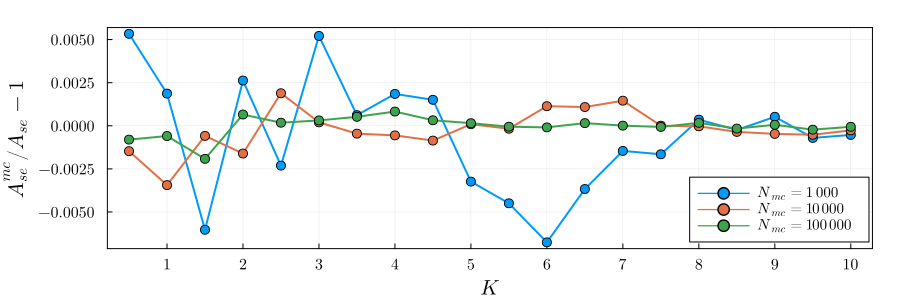

In [59]:
plot1 = plot(0.5:0.5:10,
               [relative_Nmc1K,relative_Nmc10K,relative_Nmc100K],
               label = [L"$N_{mc}=1\,000$" L"$N_{mc}=10\,000$" L"$N_{mc}=100\,000$"],
               #label = ["1K" "10K" "100K"],
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.25),
               size = (900, 300),
               ylabel = L"A_{se}^{mc}/A_{se} -1",
               xlabel = L"K",
            #    yerror= [error_relative_Nmc1K,error_relative_Nmc10K],
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

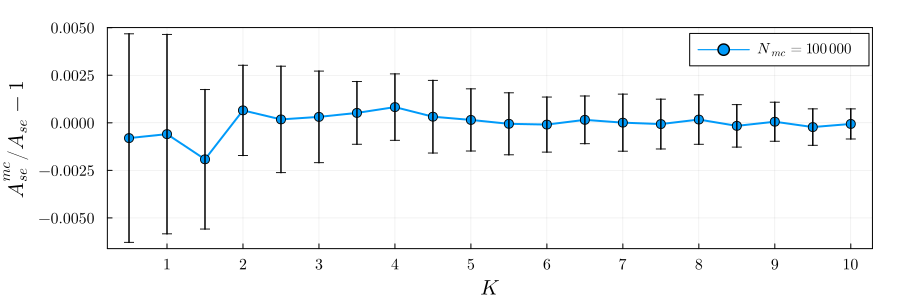

In [60]:
plot2 = plot(0.5:0.5:10,
               relative_Nmc100K,
            #   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
               label =  L"$N_{mc}=100\,000$",
               #title = ["Comparison with exact"],
               markershape = [:circle :circle :circle],
               shape = [:circle :circle :circle],
               xticks = 1:1:10,
               legend = (0.85,0.90),
               size = (900, 300),
               ylabel = L"A_{se}^{mc}/A_{se} -1",
               xlabel = L"K",
               yerror= error_relative_Nmc100K,
               markerstrokewidth = 1.5,
               linewidth=2,
               markersize = 5,
               )

In [61]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1) + c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [4.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K[10:end], c0)
fit.param;

In [62]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
  0.5861875382708509
 29.963739081667764
 62.54939562225247
  4.820338209016951e6

In [63]:
function get_data_mu16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.167/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mu16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_0.167/ib_1/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mu16 = get_self_energy_exact_mu16().amp[2:end];
function get_data_mu0(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_0.0/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mu0()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_0.0/ib_1/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mu0 = get_self_energy_exact_mu0().amp[2:end];
function get_data_mum16(Nmc, trial)
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/monte_carlo/Nmc_$(Nmc)/BF/weight_-0.167/ib_1/ampls_cutoff_10_trial_$(trial).csv",
        ),
    )
end

function get_self_energy_exact_mum16()
    DataFrame(
        CSV.File(
            "$(BASE_DATA_DIRECTORY)/self_energy/jb_0.5/exact/BF/weight_-0.167/ib_1/ampls_cutoff_10.csv",
        ),
    )
end

exact_amplitude_mum16 = get_self_energy_exact_mum16().amp[2:end];
layers_trials_mu16 = DataFrame()
for trial in 1:20
    layers_trials_mu16[!,"$(trial)"]=[get_data_mu16(100000, trial).amp[id] - get_data_mu16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu16 =  [mean(row) for row in eachrow(layers_trials_mu16)];
layers_variance_mu16 =  [var(row) for row in eachrow(layers_trials_mu16)];
amplitude_Nmc100K_mu16 = [sum(layers_average_mu16[1:id]) for id in 1:20];
error_Nmc100K_mu16 = sqrt.([sum(layers_variance_mu16[1:id]) for id in 1:20]);


relative_Nmc100K_mu16 = amplitude_Nmc100K_mu16./exact_amplitude_mu16 .-1;
error_relative_Nmc100K_mu16 = error_Nmc100K_mu16./exact_amplitude_mu16;
layers_trials_mu0 = DataFrame()
for trial in 1:20
    layers_trials_mu0[!,"$(trial)"]=[get_data_mu0(100000, trial).amp[id] - get_data_mu0(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mu0 =  [mean(row) for row in eachrow(layers_trials_mu0)];
layers_variance_mu0 =  [var(row) for row in eachrow(layers_trials_mu0)];
amplitude_Nmc100K_mu0 = [sum(layers_average_mu0[1:id]) for id in 1:20];
error_Nmc100K_mu0 = sqrt.([sum(layers_variance_mu0[1:id]) for id in 1:20]);

relative_Nmc100K_mu0 = amplitude_Nmc100K_mu0./exact_amplitude_mu0 .-1;
error_relative_Nmc100K_mu0 = error_Nmc100K_mu0./exact_amplitude_mu0;
layers_trials_mum16 = DataFrame()
for trial in 1:20
    layers_trials_mum16[!,"$(trial)"]=[get_data_mum16(100000, trial).amp[id] - get_data_mum16(100000, trial).amp[id-1] for id in 2:21]
end

layers_average_mum16 =  [mean(row) for row in eachrow(layers_trials_mum16)];
layers_variance_mum16 =  [var(row) for row in eachrow(layers_trials_mum16)];
amplitude_Nmc100K_mum16 = [sum(layers_average_mum16[1:id]) for id in 1:20];
error_Nmc100K_mum16 = sqrt.([sum(layers_variance_mum16[1:id]) for id in 1:20]);


relative_Nmc100K_mum16 = amplitude_Nmc100K_mum16./exact_amplitude_mum16 .-1;
error_relative_Nmc100K_mum16 = error_Nmc100K_mum16./exact_amplitude_mum16;

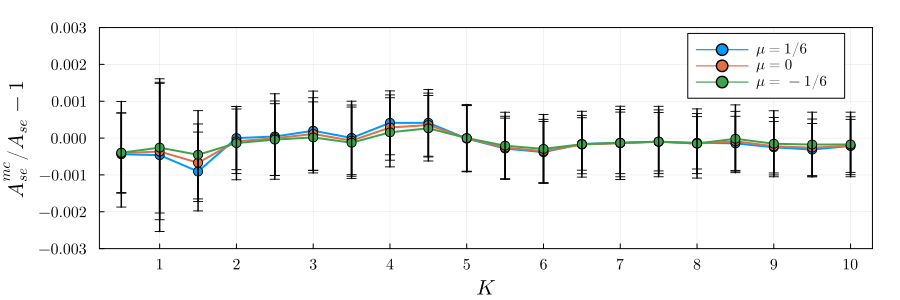

In [64]:
plot(0.5:0.5:10,
   relative_Nmc100K_mu16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu = 1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
    ylim = (-0.003, 0.003),
   ylabel = L"A_{se}^{mc}/A_{se} -1",
   xlabel = L"K",
   yerror= error_relative_Nmc100K_mu16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )
   
plot!(0.5:0.5:10,
   relative_Nmc100K_mu0,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=0$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{se}^{mc}/A_{se} -1",
   xlabel = L"K",
   yerror= error_relative_Nmc100K_mu0,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

plot!(0.5:0.5:10,
   relative_Nmc100K_mum16,
#   label = [L"$N_{mc}=1000$",L"$N_{mc}=1000$"],
   label =  L"$\mu=-1/6$",
   #title = ["Comparison with exact"],
   markershape = [:circle :circle :circle],
   shape = [:circle :circle :circle],
   xticks = 1:1:10,
   legend = (0.85,0.90),
   size = (900, 300),
   ylabel = L"A_{se}^{mc}/A_{se} -1",
   xlabel = L"K",
   yerror= error_relative_Nmc100K_mum16,
   markerstrokewidth = 1.5,
   linewidth=2,
   markersize = 5,
   )

In [65]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu16[10:end], c0)
fit.param

4-element Vector{Float64}:
  4.0675781273451825
  1.279219441680241
  6.09216711085466
 14.289278571931852

In [41]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.06416715477836486
 0.30887287418427634
 0.3075038459769679
 8.925591470243395

In [42]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mu0[10:end], c0)
fit.param

4-element Vector{Float64}:
  2.9810486937266076
  1.9465492507540985
  3.633002425846632
 -0.6118050276725184

In [43]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.03375390723227692
 0.23181017453620537
 0.5575769941403824
 3.1870172258142895

In [44]:
@. model(K, c) = c[2] * K^c[1]+ c[3] * K^(c[1]-1)+c[4]
# general range for which we have the data
cutoffs = 0.5:0.5:10
# initial values for the parameters. The initial value for the scaling is set to 1 by default but can be scpecified
c0 = [3.0,1.0,1.0,1.0]
# We perform the Least Squares Fit considering just the values from K = 4 to 10 with steps of 1/2
fit = curve_fit(model, cutoffs[10:end], amplitude_Nmc100K_mum16[10:end], c0)
fit.param

4-element Vector{Float64}:
  1.9565538507964029
  2.7127338502146987
  0.8298327291041698
 -0.5984858552092793

In [45]:
margin_error(fit, 0.05)

4-element Vector{Float64}:
 0.025567256087982364
 0.24527435508894951
 0.9977050551620279
 1.7131371773958473